# Classification with the perceptron and logistic regression

__Individual assignment__

Author of the assignment: Pierre Nugues

__Student name__: Osama Eldawebi

## Objectives

The objectives of this second assignment are to:

1.  Write a linear regression program using gradient descent;
2.  Write linear classifiers using the perceptron algorithm and logistic regression;
3.  Experiment variations of the algorithms;
4.  Evaluate your classifiers;
5.  Experiment with popular tools;
6.  Read a scientific article on optimization techniques and comment it;
7.  Present your code, results, and comments in a short dissertation.

## Overview

The gradient descent is a basic technique to estimate linear discriminant functions. You will first use the gradient descent method to implement linear regression. You will then program the perceptron algorithm. Finally, you will improve the threshold function with the logistic curve (logistic regression). You will try various configurations and study their influence on the learning speed and accuracy.

##  Programming language
As programming language, you will use Python and write your code in this notebook.

You need to have a comprehensive Python distribution such as Anaconda (https://www.anaconda.com/products/individual). This distribution is available on the student computers at the computer science department.
Finally, you start a notebook by typing:

`jupyter lab`

in a terminal window and you select the notebook by clicking on it in the left pane.
You run the pieces of code by typing shift+enter.

## Imports
Imports you may use

In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

## Linear Regression

You will implement the gradient descent method as explained in pages 719--720 in Russell-Norvig and in the slides to compute regression lines. You will implement the stochastic and batch versions of the algorithm.

You must try to do it yourself first. If you encounter difficulties, you also have the solution to this exercise in the section _Solution to linear regression_ below.

### Your implementation of linear regression
You will implement a regression program to predict the counts of _A_'s in a text from the total count of letters. You will apply it on two data sets corresponding to letter counts in the 15 chapters of the French and English versions of _Salammbô_, where the first column is the total count of characters and the second one, the count of A's. 

Start with either French or English and when your program ready, test it on the other language.

In [2]:
stat_fr = np.array([[36961, 2503],
                      [43621, 2992],
                      [15694, 1042],
                      [36231, 2487],
                      [29945, 2014],
                      [40588, 2805],
                      [75255, 5062],
                      [37709, 2643],
                      [30899, 2126],
                      [25486, 1784],
                      [37497, 2641],
                      [40398, 2766],
                      [74105, 5047],
                      [76725, 5312],
                      [18317, 1215]])

stat_en = np.array([[35680, 2217],
                      [42514, 2761],
                      [15162, 990],
                      [35298, 2274],
                      [29800, 1865],
                      [40255, 2606],
                      [74532, 4805],
                      [37464, 2396],
                      [31030, 1993],
                      [24843, 1627],
                      [36172, 2375],
                      [39552, 2560],
                      [72545, 4597],
                      [75352, 4871],
                      [18031, 1119]])

From the datasets above, tell what is $\mathbf{X}$ and $\mathbf{y}$. Extract:
1. The $\mathbf{X}$ matrix, where you will have a column to model the intercept;
2. The $\mathbf{y}$ vector

from these arrays.

In [3]:
X = np.array([[1, x[0]] for x in stat_en])
y = np.array([[x[1] for x in stat_en]]).T

Scale the arrays so that they fit in the range [0, 1] on the $x$ and $y$ axes. 

In [4]:
# Inspired by Pierre's normalize function. Seems pretty good.
def normalize(Xy):
    maxima = np.amax(Xy, axis=0)
    D = np.diag(maxima)
    D_inv = np.linalg.inv(D)
    Xy = Xy @ D_inv
    return (Xy, maxima)

X, maxima_X = normalize(X)
y, maxima_y = normalize(y)
maxima = np.concatenate((maxima_X, maxima_y))
alpha = 1.0

In [5]:
X

array([[1.        , 0.47351099],
       [1.        , 0.56420533],
       [1.        , 0.20121563],
       [1.        , 0.46844145],
       [1.        , 0.39547723],
       [1.        , 0.53422603],
       [1.        , 0.98911774],
       [1.        , 0.49718654],
       [1.        , 0.41180062],
       [1.        , 0.32969264],
       [1.        , 0.48004034],
       [1.        , 0.52489649],
       [1.        , 0.96274817],
       [1.        , 1.        ],
       [1.        , 0.23929026]])

In [6]:
y

array([[0.45514268],
       [0.56682406],
       [0.20324369],
       [0.46684459],
       [0.38287826],
       [0.53500308],
       [0.98645042],
       [0.49189078],
       [0.40915623],
       [0.33401766],
       [0.48757955],
       [0.52555943],
       [0.94374872],
       [1.        ],
       [0.22972696]])

#### Gradient descent

Implement the descent functions. You will pass `X`, `y`, the learning rate in the $\alpha$ variable, the initial weight vector in `w`, the tolerance in the $\epsilon$ variable, the maximal number of epochs in `epochs`. You will return `w`.

Batch descent

In [7]:
def fit_batch(X, y, alpha, w,
                  epochs=500,
                  epsilon=1.0e-5):
    
    mod_alpha = alpha / len(X) # alpha / q (number of examples), see slide 17 on ML2
    for epoch in range(epochs):
        loss = y - (X @ w) # y - y_hat
        # We established that w0 is our intercept, so w1 is our gradient. see slide 18 on ML2
        gradient = X.T @ loss
        w = w + mod_alpha * gradient
        if np.linalg.norm(gradient) < epsilon:
            break
    return w

Stochastic descent

In [8]:
# See slide 20 on ML2
def fit_stoch(X, y, alpha, w,
                  epochs=500,
                  epsilon=1.0e-5):
    np.random.seed(0)
    idx = list(range(len(X)))
    for epoch in range(epochs):
        np.random.shuffle(idx)
        for i in idx:
            loss = y[i] - (X[i] @ w)[0]
            gradient = loss * np.array([X[i]]).T
            w = w + alpha * gradient
        if np.linalg.norm(gradient) < epsilon:
            break
    return w

#### Applying batch descent

Apply the batch descent and print the final weight values 

In [9]:
w = np.zeros(X.shape[1]).reshape((-1, 1))
w = fit_batch(X, y, alpha, w)
w

array([[-7.31744724e-04],
       [ 9.94697306e-01]])

Visualize the points of your dataset as well as the regression lines you obtain using matplotlib or another similar program.

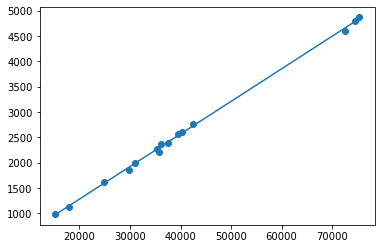

In [10]:
# Restore x and y
x_fig = [X[i][1] * maxima_X[1] for i in range(len(X))]
y_fig = [yi * maxima_y for yi in y]

# Restore w
maxima = maxima.reshape(-1, 1)
w = maxima[-1, 0] * (w / maxima[:-1, 0:1])

plt.scatter(x_fig, y_fig)
plt.plot([min(x_fig), max(x_fig)],
         [[1, min(x_fig)] @ w, [1, max(x_fig)] @ w])
plt.show()

#### Stochastic descent

In [11]:
w = np.zeros(X.shape[1]).reshape((-1, 1))
w = fit_stoch(X, y, alpha, w)
w

array([[-0.01223556],
       [ 0.97527808]])

Visualize the points of your dataset as well as the regression lines you obtain using matplotlib or another similar program.

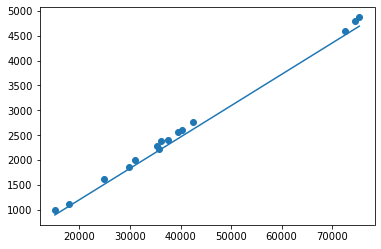

In [12]:
# Restore x and y
x_fig = [X[i][1] * maxima_X[1] for i in range(len(X))]
y_fig = [yi * maxima_y for yi in y]

# Restore w
maxima = maxima.reshape(-1, 1)
w = maxima[-1, 0] * (w / maxima[:-1, 0:1])

plt.scatter(x_fig, y_fig)
plt.plot([min(x_fig), max(x_fig)],
         [[1, min(x_fig)] @ w, [1, max(x_fig)] @ w])
plt.show()

### A solution to linear regression

To help you start this assignment, your instructor wrote two Python notebooks that solve this exercise on linear regression. You can find them here: https://github.com/pnugues/ilppp/tree/master/programs/ch04/python
The first notebook, `gradient_descent.ipynb`, only uses Python and vector operations such as the dot product that are in the `vector.py` file.
The second notebook, `gradient_descent_numpy.ipynb`, uses Numpy. It is more compact, but you need to know a bit of numpy.

To run these programs, download them on your computer as well as the other program in the import list: vector.py

The programs are also available as Python programs from
https://github.com/pnugues/ilppp/tree/master/programs/ch04/python

## Classification
You will use the same data set as for linear regression, but this time to classify a chapter as French or English. Given a pair of numbers corresponding the letter count and count of _A_, you will predict the language:
1. $\mathbf{x} = (35680, 2217)$ $\to$ $y$ = English
2. $\mathbf{x} = (37497, 2641)$ $\to$ $y$ = French

### The dataset
You will use the arrays below:
1. `X` contains the counts of letters and of _A_ s as well as a column of ones for the intercept;
2. `y` contains the classes, where 0 is for English and 1 for French.

In [13]:
X = [[1.0, 35680.0, 2217.0],
     [1.0, 42514.0, 2761.0],
     [1.0, 15162.0, 990.0],
     [1.0, 35298.0, 2274.0],
     [1.0, 29800.0, 1865.0],
     [1.0, 40255.0, 2606.0],
     [1.0, 74532.0, 4805.0],
     [1.0, 37464.0, 2396.0],
     [1.0, 31030.0, 1993.0],
     [1.0, 24843.0, 1627.0],
     [1.0, 36172.0, 2375.0],
     [1.0, 39552.0, 2560.0],
     [1.0, 72545.0, 4597.0],
     [1.0, 75352.0, 4871.0],
     [1.0, 18031.0, 1119.0],
     [1.0, 36961.0, 2503.0],
     [1.0, 43621.0, 2992.0],
     [1.0, 15694.0, 1042.0],
     [1.0, 36231.0, 2487.0],
     [1.0, 29945.0, 2014.0],
     [1.0, 40588.0, 2805.0],
     [1.0, 75255.0, 5062.0],
     [1.0, 37709.0, 2643.0],
     [1.0, 30899.0, 2126.0],
     [1.0, 25486.0, 1784.0],
     [1.0, 37497.0, 2641.0],
     [1.0, 40398.0, 2766.0],
     [1.0, 74105.0, 5047.0],
     [1.0, 76725.0, 5312.0],
     [1.0, 18317.0, 1215.0]]
y = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
     1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

We visualize it

In [14]:
x_fr = [x[1] for i, x in enumerate(X) if y[i] == 1]
y_fr = [x[2] for i, x in enumerate(X) if y[i] == 1]
x_en = [x[1] for i, x in enumerate(X) if y[i] == 0]
y_en = [x[2] for i, x in enumerate(X) if y[i] == 0]

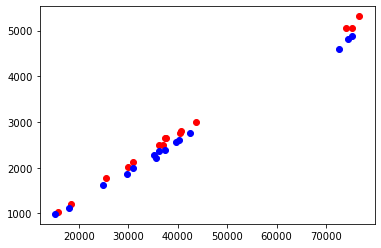

In [15]:
plt.scatter(x_fr, y_fr, color='red')
plt.scatter(x_en, y_en, color='blue')

### Normalize the dataset

Gradient descent algorithms can be very sensitive to the range. Therefore, we normalize the dataset.

In [16]:
def normalize(observations):
    maxima = [max([obs[i] for obs in observations]) for i in range(len(observations[0]))]
    return ([[obs[i] / maxima[i]
              for i in range(len(observations[0]))] for obs in observations],
            maxima)

In [17]:
X_norm, maxima = normalize(X)
X_norm

[[1.0, 0.4650374714890844, 0.4173569277108434],
 [1.0, 0.5541088302378625, 0.5197665662650602],
 [1.0, 0.19761485826001954, 0.18637048192771086],
 [1.0, 0.460058651026393, 0.42808734939759036],
 [1.0, 0.3884001303356142, 0.3510918674698795],
 [1.0, 0.5246660149885957, 0.49058734939759036],
 [1.0, 0.9714173998044966, 0.9045557228915663],
 [1.0, 0.4882893450635386, 0.4510542168674699],
 [1.0, 0.4044314108830238, 0.37518825301204817],
 [1.0, 0.32379276637341153, 0.30628765060240964],
 [1.0, 0.47144998370804825, 0.4471009036144578],
 [1.0, 0.5155034213098729, 0.4819277108433735],
 [1.0, 0.9455197132616487, 0.8653990963855421],
 [1.0, 0.9821049201694363, 0.916980421686747],
 [1.0, 0.2350081459758879, 0.21065512048192772],
 [1.0, 0.48173346366894754, 0.4711972891566265],
 [1.0, 0.5685369827305311, 0.5632530120481928],
 [1.0, 0.2045487129358097, 0.19615963855421686],
 [1.0, 0.47221896383186707, 0.46818524096385544],
 [1.0, 0.39028999674160963, 0.37914156626506024],
 [1.0, 0.5290061909416748, 

## The Perceptron

1. Write the perceptron program as explained in pages 723--725 in Russell-Norvig and in the slides and run it on your data set. As suggested program structure, use two functions: 
 * `fit(X, y)` that will return `w` (the model). You can choose a stochastic or batch variant;
 * `predict(X, w)` that will return `y_hat`. You can encapsulate these functions in a class and, of course, add more parameters.
2. As a stop criterion, you will use the number of misclassified examples.
3. You will report the parameters you have used and the weight vector

You can use numpy or not. The next cells are just suggested steps. You can implement it your way.

### The `predict(X, w)` function
Write a `predict(X, w)` function that given a matrix of observations $\mathbf{X}$ and a weight vector $\mathbf{w}$ will return a $\mathbf{\hat{y}}$ vector classes (0 or 1)

In [18]:
def predict(X, w):
    y = [1 if x @ w >= 0 else 0 for x in X]
    return y

### The `fit(X, y)` function

Write a `fit(X, y)` function that given a matrix of observations $\mathbf{X}$ and a vector of responses $\mathbf{y}$ will return a weight $\mathbf{w}$ vector. You may use the other arguments of the function, notably the number of misclassified examples to define the stop condition.

In [19]:
def fit_stoch(X, y,
              epochs=1000,
              max_misclassified=0,
              verbose=True):
    np.random.seed(0)
    w = np.zeros(X.shape[1]).reshape((-1, 1))
    idx = list(range(len(X)))
    for epoch in range(epochs):
        np.random.shuffle(idx)
        for i in idx:
            y_hat = predict(X, w)
            loss = np.array(y) - np.array(y_hat)
            gradient = loss[i] * np.array([X[i]]).T
            w = w + gradient
        if np.count_nonzero(loss) < max_misclassified:
            print(epoch)
            break
    return w

### Fitting the dataset

In [20]:
w = fit_stoch(np.array(X_norm), y)
w

array([[ 0.        ],
       [-5.19731509],
       [ 5.45707831]])

In [21]:
w = [w[i] * maxima[-1] / maxima[i] for i in range(len(w))]
print("Restored weights", w)
w = [w[j] / w[-1] for j in range(len(w))]
print("Weights with y set to 1", w)

Restored weights [array([0.]), array([-0.35983236]), array([5.45707831])]
Weights with y set to 1 [array([0.]), array([-0.06593865]), array([1.])]


### Visualizing the results

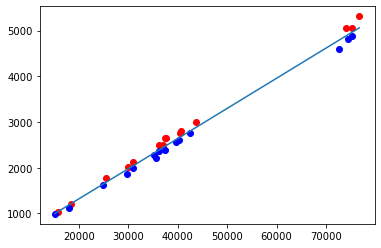

In [22]:
plt.scatter(x_fr, y_fr, color='red')
plt.scatter(x_en, y_en, color='blue')
plt.plot([min(x_fr + x_en), max(x_fr + x_en)],
             [-w[1] * min(x_fr + x_en) - w[0], -w[1] * max(x_fr + x_en) - w[0]])

### Evaluation
Evaluate your perceptron using the leave-one-out cross validation method. You will have to train and run 30 models. In each train/run session, you will train on 29 samples and evaluate on the remaining sample. You have then either a correct or a wrong classification. You will sum these classifications, i.e. the number of correct classifications, to get your final evaluation, for instance 29/30.

In [23]:
def leave_one_out_cross_val(X, y, fitting_function):
    X = np.array(X)
    y = np.array(y)
    models = 30
    correctly_classified = 0
    for i in tqdm(range(models)):
        idx = np.arange(models)
        np.random.shuffle(idx)
        ridx = idx[:29]
        left_out = [29]
        w = fitting_function(X[ridx, :], y[ridx])
        y_hat = predict([X[left_out, :]], w)
        correctly_classified += 1 if y[left_out] - y_hat == 0 else 0
    return correctly_classified / models

In [24]:
stoch_accuracy = leave_one_out_cross_val(X_norm, y, fit_stoch)
print('Cross-validation accuracy (stochastic):', stoch_accuracy)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:59<00:00,  1.99s/it]

Cross-validation accuracy (stochastic): 1.0


## Logistic Regression
From your perceptron program, implement logistic regression. You can either follow the description from the textbook, S. Russell and R. Norvig, _Artificial Intelligence_, 2010, pages 725--727, or the slides. You can either implement the stochastic or the batch version of the algorithm, or both versions. As stop criterion, you will use either the norm of the gradient or the norm of the difference between two consecutive weight vectors. You will also set a maximal number of epochs. Run the resulting program on your data set.

Write the logistic function, where the $x$ input is a real number.

In [25]:
def logistic(x):
    try:
        return 1 / (1 + math.exp(-x))
    except OverflowError:
        return 0 if x < 0 else 1

### The `predict(X, w)` function

Write a `predict_proba()` function that given a matrix of observations $\mathbf{X}$ and a weight vector $\mathbf{w}$ will return a vector of probabilities to belong to class 1: The vector will consist of $P(1|\mathbf{x}_i)$ for all the $i$ rows of $\mathbf{X}$.

In [26]:
def predict_proba(X, w):
    return np.array([logistic(float(x @ w)) for x in X])

Write a `predict(X, w)` function that given a matrix of observations $\mathbf{X}$ and a weight vector $\mathbf{w}$ will return the class. You will use `predict_proba()` and set the threshold to belong to class 1 to 0.5.

In [27]:
def predict(X, w):
    return [1 if predict_proba([x],w) >= 0.5 else 0 for x in X]

### The `fit(X, y)` function

You will now write the `fit(X, y)` function as with the perceptron. You may call it `fit_stoch(X, y)` or `fit_batch(X, y)`. Use the parameters given in the cell below.

In [28]:
def fit_stoch(X, y, alpha=100,
              epochs=1000,
              epsilon=1.0e-4,
              verbose=False):
    X = np.array(X)
    y = np.array(y)
    np.random.seed(0)
    w = np.zeros(X.shape[1]).reshape((-1,)).T
    idx = list(range(len(X)))
    prev_w = w
    for epoch in range(epochs):
        np.random.shuffle(idx)
        for i in idx:
            likelihoods = predict_proba(X,w)
            y_hat = predict(X, w)
            loss = np.array(y) - np.array(y_hat)
            gradient = X[i] * loss[i]
            w = w + (alpha * gradient)
        
        if verbose:
            print(f'Gradient: {np.linalg.norm(gradient)}, Likelihood: {likelihoods[i]}')
            
        diff_w = w - prev_w
        if np.linalg.norm(diff_w) < epsilon:
            break
        prev_w = w
        
    return w

In [29]:
w = fit_stoch(X_norm, y, verbose=True)
w

Gradient: 1.6257069613529074, Likelihood: 1.0
Gradient: 1.2484726806992217, Likelihood: 2.7677862166221584e-58
Gradient: 0.0, Likelihood: 0.9999999999531164
Gradient: 1.2058582069742008, Likelihood: 9.730699635787456e-42
Gradient: 0.0, Likelihood: 1.0
Gradient: 0.0, Likelihood: 6.43586041423313e-15
Gradient: 0.0, Likelihood: 8.458834092937597e-82
Gradient: 1.2007815750820405, Likelihood: 1.0
Gradient: 0.0, Likelihood: 5.772740237637309e-33
Gradient: 0.0, Likelihood: 1.0
Gradient: 0.0, Likelihood: 2.099257179564494e-53
Gradient: 1.0532383318328666, Likelihood: 1.2872843771773594e-32
Gradient: 0.0, Likelihood: 1.0
Gradient: 0.0, Likelihood: 1.0
Gradient: 1.1810642408855154, Likelihood: 0.999999999999972
Gradient: 1.1384527257758614, Likelihood: 6.230382104243917e-54
Gradient: 0.0, Likelihood: 1.0
Gradient: 0.0, Likelihood: 0.03254951542391006
Gradient: 0.0, Likelihood: 1.0
Gradient: 0.0, Likelihood: 2.523265339269865e-80
Gradient: 0.0, Likelihood: 1.0
Gradient: 1.2443352807505466, Likeli

array([   0.        , -519.73150863,  545.70783133])

In [30]:
w = [w[i] / maxima[i] for i in range(len(w))]
print("Restored weights", w)
w = [w[j] / w[-1] for j in range(len(w))]
print("Weights with y set to 1", w)

Restored weights [0.0, -0.006773952540042157, 0.10273114294527516]
Weights with y set to 1 [0.0, -0.06593864670278844, 1.0]


### Visualizing the results

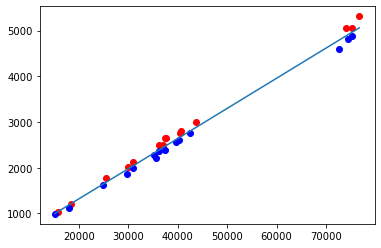

In [31]:
plt.scatter(x_fr, y_fr, color='red')
plt.scatter(x_en, y_en, color='blue')
plt.plot([min(x_fr + x_en), max(x_fr + x_en)],
         [-w[1] * min(x_fr + x_en) - w[0], -w[1] * max(x_fr + x_en) - w[0]])
plt.show()

### Evaluation
Evaluate your logistic regression using the leave-one-out cross validation method as with the perceptron

In [32]:
def leave_one_out_cross_val(X, y, fitting_function):
    X = np.array(X)
    y = np.array(y)
    models = 30
    correctly_classified = 0
    for i in tqdm(range(models)):
        idx = np.arange(models)
        np.random.shuffle(idx)
        ridx = idx[:29]
        left_out = [29]
        w = fitting_function(X[ridx, :], y[ridx])
        y_hat = predict(X[left_out, :], w)
        correctly_classified += 1 if y[left_out] - y_hat == 0 else 0
    return correctly_classified / models

In [33]:
stoch_accuracy = leave_one_out_cross_val(X, y, fit_stoch)
print('Cross-validation accuracy (batch):', stoch_accuracy)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.81it/s]

Cross-validation accuracy (batch): 1.0


## Visualizing the logistic surface

In [34]:
def plot_logistic_surf(x_range, y_range, w_opt):
    z_axis = np.array([[0.0] * len(y_range) for i in range(len(x_range))])
    x_axis, y_axis = np.meshgrid(x_range, y_range)
    z_axis = z_axis.reshape(x_axis.shape)

    # We compute the probability surface as a function of x and y
    for i in range(len(x_range)):
        for j in range(len(y_range)):
            z_axis[j, i] = logistic(np.dot([1, x_range[i], y_range[j]], w_opt))
    return x_axis, y_axis, z_axis

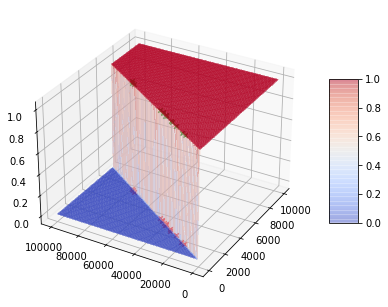

In [35]:
x_range = np.linspace(0, 100000, 200)
y_range = np.linspace(0, 10000, 200)
#w = [2.073225839414742, -0.049125455233437906, 0.7440143556104162]

x_axis, y_axis, z_axis = plot_logistic_surf(x_range, y_range, w)

fig = plt.figure()
ax = Axes3D(fig)
# ax = fig.gca(projection='3d')

surf = ax.plot_surface(y_axis, x_axis, z_axis, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
# We plot the observations
for x, y_class in zip(X, y):
    if y_class == 1:
        ax.scatter(x[2], x[1], y_class, color='green', marker='x')
    else:
        ax.scatter(x[2], x[1], y_class, color='red', marker='x')

ax.elev = 30 
ax.azim = -150
plt.show()

## Programming logistic regression with popular APIs
Should you use logistic regression in a project, you will probably resort to existing libraries. In the next cells, you will apply the logistic regression classification with two popular APIs:
1. sklearn
2. Keras

`sklearn` is included in anaconda.
You will install the rest with:
```
pip install --upgrade keras tensorflow tensorflow-addons 
```
You will read and run the code in the cells below.

All these APIs are built on numpy and we convert the dataset into numpy if you have not done it already

In [36]:
X = np.array(X)
X_norm = np.array(X_norm)
y = np.array(y)

They also handle the intercept so we do not need the first column of ones.

In [37]:
X = X[:, 1:]
X_norm = X_norm[:, 1:]

### sklearn
Using the dataset of English and French datapoints, we apply logistic regression with the sklearn API. We need the `LogisticRegression` class, the fit() and predict() functions. The weights are in the `coef_` field.

In [38]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model = model.fit(X, y)
model.coef_

array([[-0.03372363,  0.51169867]])

We predict the classes of the $\mathbf{X}$ with the `predict()` function

In [39]:
model.predict(X)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

We predict the class probabilities of the $\mathbf{X}$ with the `predict_proba()` function

In [40]:
model.predict_proba(X)

array([[1.00000000e+00, 1.28980319e-30],
       [9.99999999e-01, 8.16295157e-10],
       [9.91302434e-01, 8.69756611e-03],
       [1.00000000e+00, 2.35657080e-12],
       [1.00000000e+00, 1.01085544e-22],
       [1.00000000e+00, 3.56287478e-11],
       [1.00000000e+00, 1.62389438e-24],
       [1.00000000e+00, 5.76610689e-17],
       [1.00000000e+00, 2.72458519e-12],
       [9.94843591e-01, 5.15640906e-03],
       [9.89714656e-01, 1.02853437e-02],
       [1.00000000e+00, 4.22127774e-11],
       [1.00000000e+00, 1.22665951e-41],
       [1.00000000e+00, 7.37721442e-22],
       [1.00000000e+00, 3.90177203e-16],
       [1.33226763e-15, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [1.92390717e-02, 9.80760928e-01],
       [0.00000000e+00, 1.00000000e+00],
       [1.01629571e-09, 9.99999999e-01],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.000000

### Keras
Using the dataset of English and French datapoints, we apply logistic regression with Keras. We need the `Sequential` and `Dense` classes.

In [41]:
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense

In [42]:
model = Sequential()
model.add(Dense(1, input_dim=2, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


We fit the model

In [43]:
model.fit(X, y, epochs=1500, batch_size=4, verbose=0)

In [44]:
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [45]:
model.predict(X)

array([[6.5691823e-22],
       [1.2959312e-06],
       [5.9300035e-02],
       [1.3845832e-08],
       [3.0481878e-16],
       [1.2106386e-07],
       [7.9974250e-17],
       [6.4643724e-12],
       [1.3116173e-08],
       [5.8127880e-02],
       [1.3556713e-01],
       [1.3345861e-07],
       [2.3583634e-29],
       [7.1771160e-15],
       [1.2594593e-11],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.7294891e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.7656316e-01]], dtype=float32)

In [46]:
model.predict_classes(X)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

If you do not obtain a correct classification, rerun the training with more epochs.

## Reading
You will read the article *An overview of gradient descent optimization algorithms* by Ruder (2017) and you will outline the main characteristics of all the optimization algorithms the author describes. This part should be of about one to two pages. Link to the article: https://arxiv.org/abs/1609.04747

If you understand French, or using Google translate, you may also want to read the original article on gradient descent by Cauchy here:  https://gallica.bnf.fr/ark:/12148/bpt6k2982c/f540.item.


### Report

The assignment must be documented in the report, which should contain the following:

*   The name of the author, the title of the assignment, and any relevant information on the front page;
*   A presentation of the assignment and the possible improvements you would have brought;
*   A presentation of your implementation;
*   A print-out of the example set(s) and the resulting weight vectors;
*   Comments on the results you have obtained, including your cross validation;
*   A short dissertation on the optimization algorithms from Ruder's paper.

Please, typeset and format your report consistently. You must use Latex. Documents written using MS Word or any similar format will not be considered.

You may have a look at the code in the textbook code repository (or any other implementations), but the code you hand in must be your work.

## Submission
Submit the notebook and the report to Canvas (two files). Do not include the code printout in the report, but only comments on its interesting parts. You will submit the notebook as a separate file.